**Autor: Arturo Garza Campuzano**

**Matrícula: A00828096**

# Análisis y Reporte sobre el desempeño del modelo

El dataset utilizado en esta implementación es *Diabetes Dataset* y se puede encontrar en https://www.kaggle.com/datasets/mathchi/diabetes-data-set. En este mismo sitio se puede consultar una breve descripción del mismo.

En este caso se implementó un **clasificador de árbol de decisión**, cuyo propósito es predecir, en base a datos médicos, si un paciente tiene diabetes o no. Por lo tanto, este **problema** puede ser considerado como de **clasificación**.

## Importar módulos

In [79]:
# Uso general
import math
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Division en subconjuntos de train, test & validation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Modelo
from sklearn.tree import DecisionTreeClassifier
# Analisis de desempeno
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

## Cargar datos

In [80]:
# Este bloque de codigo no es necesario si el archivo esta guardado localmente
from google.colab import drive
drive.mount('/content/drive')

# Cambiar ruteo con de acuerdo a la ubicacion los archivos en su dispositivo
diabetes_df = pd.read_csv('/content/drive/MyDrive/TC3006C101_A00828096/Aprendizaje_Maquina/diabetes.csv')

#Descripcion de datos
cantidad_registros = len(diabetes_df)
numero_caracteristicas = len(diabetes_df.columns) - 1
valores_salida = diabetes_df["Outcome"].unique()
print("Descripcion de Diabetes Dataset")
print(f"Cantidad de registros: {cantidad_registros}")
print(f"Número de características: {numero_caracteristicas}")
print(f"Valores de salida: {valores_salida}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Descripcion de Diabetes Dataset
Cantidad de registros: 768
Número de características: 8
Valores de salida: [1 0]


## Limpieza del conjunto

El valor cero no es aceptable para algunas variables. Se reemplazan estos valores con la media respectiva a cada variable.

In [81]:
# Se reemplazan los ceros por la media de las variables
zero_not_accepted = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI', "Insulin"]

for column in zero_not_accepted:
  diabetes_df[column] = diabetes_df[column].replace(0, np.NaN)
  mean = int(diabetes_df[column].mean(skipna = True))
  diabetes_df[column] = diabetes_df[column].replace(np.NaN, mean)

## Separación de datos en subconjuntos

Se divide el conjunto de datos en entrenamiento (70%), prueba (15%) y validación (15%).

In [82]:
# Seleccion de columnas de train_df
n = len(diabetes_df.columns) - 1
X = diabetes_df.iloc[:, 0:n]
y = diabetes_df.iloc[:, n]

# Dividir el dataset en conjuntos de entrenamiento (70%), validación (15%) y prueba (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Cualquier algoritmo en el que se calcula la distancia o se asume normalidad, los atributos se escalan. En este caso, se asume la normalidad de los datos y, por lo tanto, se escalan.

In [83]:
# Escalamiento de variables
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
X_val = sc_X.transform(X_val)

In [84]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.682292,72.386719,29.108073,155.28125,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.435999,12.096642,8.791221,85.02155,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.00000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.50000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,155.00000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,155.00000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.00000,67.100000,2.420000,81.000000,1.000000


## Entrenamiento del modelo

Partiendo del modelo establecido en [Implementacion_Framework.ipynb](https://colab.research.google.com/drive/1tTavKiv0ntTgggibxVhqNbsUdyzxwoEg?usp=sharing) se ajustan diferentes parámetrios e hiper-parámetros para refinar el modelo. Por el momento, se sostiene como hipótesis que el modelo DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_split=70) es el que otorga mejores resultados.

### Modelo hipótesis

Para analizar más a fondo el modelo hipótesis se grafica el error de las predicciones realizadas por el modelo contra el tamaño del subconjunto de entrenamiento.

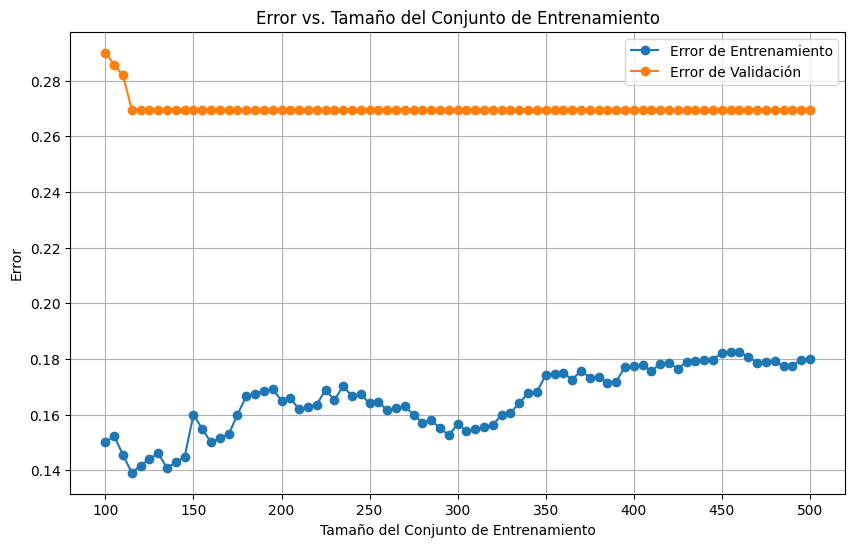

In [85]:
def error_modelo(modelo):
  # Inicializa listas de errores para subconjuntos
  train_errors = []
  val_errors = []

  # Tamanos de subconjunto
  training_sizes = range(100, 501, 5)

  for size in training_sizes:
      # Selecciona un subconjunto de entrenamiento del tamano actual
      X_train_subset = X_train[:size]
      y_train_subset = y_train[:size]
      X_val_subset = X_val[:size]
      y_val_subset = y_val[:size]

      # Realiza predicciones en los conjuntos de entrenamiento y validacion
      y_train_pred = modelo.predict(X_train_subset)
      y_val_pred = modelo.predict(X_val_subset)

      # Calcula los errores de entrenamiento y validacion
      train_error = 1 - accuracy_score(y_train_subset, y_train_pred)
      val_error = 1 - accuracy_score(y_val_subset, y_val_pred)

      # Agrega los errores a las listas
      train_errors.append(train_error)
      val_errors.append(val_error)

  plt.figure(figsize=(10, 6))
  plt.plot(training_sizes, train_errors, label='Error de Entrenamiento', marker='o')
  plt.plot(training_sizes, val_errors, label='Error de Validación', marker='o')
  plt.title('Error vs. Tamaño del Conjunto de Entrenamiento')
  plt.xlabel('Tamaño del Conjunto de Entrenamiento')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
  plt.show()

# Modelo hipotesis
tree = DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_split=70)
tree.fit(X_train, y_train)
error_modelo(tree)

**Observaciones:**
- Los errores de ambos subconjuntos estan muy separados, esto es señal de que hay un sobreajuste del modelo (overffiting). Por lo tanto, se tiene una **varianza media** y un **sesgo bajo**.
- El error del modelo incrementa a medida que el subconjunto de entrenamiento crece, indicador de que el modelo no es el ideal.

Por lo tanto, el modelo hipótesis no es el indicado porque padece de overfitting. Hay muy poco error en subset de entrenamiento y no generaliza bien.

### Ajuste de parámetro max_depth

Considerando estas observaciones se toma la decisión de ajustar el parámetro **max_depth** para reducir el overfitting del modelo anterior. A continuación, se busca el la valor de **max_depth** ideal para reducir el error de validación y entrenamiento.

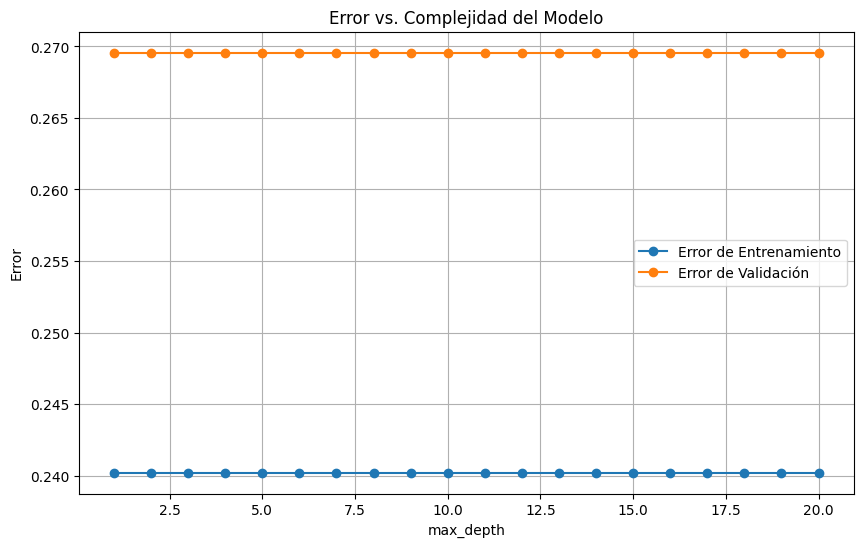

In [100]:
# Define una lista de valores de max_depth que se desea probar
max_depth_values = range(1, 21, 1)

# Inicializa listas para almacenar los errores de entrenamiento y validacion
train_errors = []
val_errors = []

# Itera a traves de los valores de max_depth
for max_depth in max_depth_values :
    # Crea y entrena un modelo de arbol con la max_depth actual
    tree = DecisionTreeClassifier(criterion="entropy", max_depth=max_depth, min_samples_split=70)
    tree.fit(X_train, y_train)

    # Realiza predicciones en los conjuntos de entrenamiento y validacion
    y_train_pred = tree.predict(X_train)
    y_val_pred = tree.predict(X_val)

    # Calcula el error de entrenamiento y validacion
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    val_error = 1 - accuracy_score(y_val, y_val_pred)

    # Agrega los errores a las listas
    train_errors.append(train_error)
    val_errors.append(val_error)

# Crea la grafica de error vs. complejidad del modelo
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_errors, label='Error de Entrenamiento', marker='o')
plt.plot(max_depth_values, val_errors, label='Error de Validación', marker='o')
plt.title('Error vs. Complejidad del Modelo')
plt.xlabel('max_depth')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

**Observación:** El mejor valor de max_depth parece ser de cinco, hay una reducción significativa en los subconjuntos de validación y entrenamiento.

Ajustando el parámetro max_depth a cinco, se revisa si hay una reducción de overffiting del modelo.

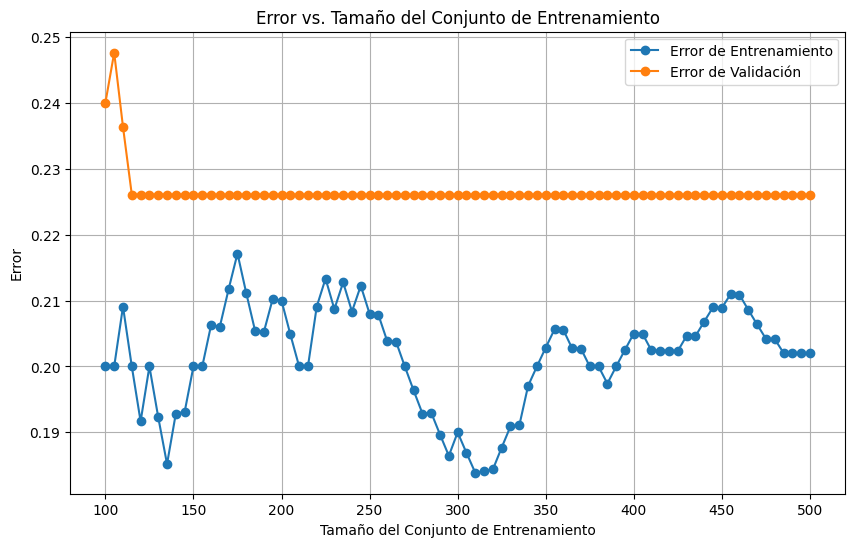

In [89]:
# Modelo con ajuste de max_depth
tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_split=70)
tree.fit(X_train, y_train)
error_modelo(tree)

**Observaciones:**
- Hay una reducción de la diferencia de error entre ambos subconjuntos. Por lo tanto, el ajuste del modelo disminuyó en cuanto a sobreajuste (overffiting). Ahora hay una **varianza** más **baja** y un **sesgo bajo**.
- El error del subconjunto de entrenamiento es muy volátil.

### Ajuste de hiper-parámetro min_samples_split

Con el fin de reducir la volatilidad en el error de entrenamiento y reducir todavía más la **varianza**, se ajusta el hiper-parámetro **min_samples_split**. A continuación, se busca el valor de **min_samples_split** que reduzca el error de ambos subconjuntos.

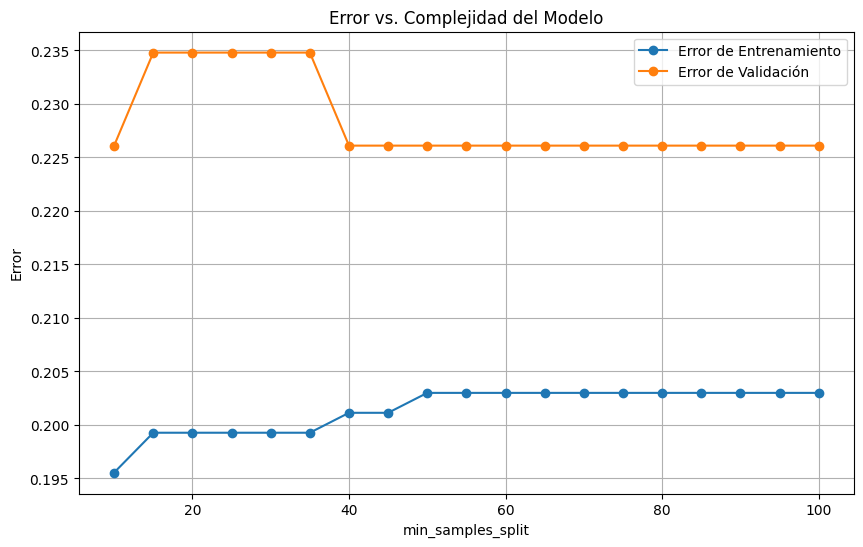

In [90]:
# Define una lista de valores de min_samples_split que se desea probar
min_samples_split_values = range(10, 101, 5)

# Inicializa listas para almacenar los errores de entrenamiento y validacion
train_errors = []
val_errors = []

# Itera a través de los valores de min_samples_split
for min_samples_split in min_samples_split_values :
    # Crea y entrena un modelo de arbol con la min_samples_split actual
    tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_split=min_samples_split)
    tree.fit(X_train, y_train)

    # Realiza predicciones en los conjuntos de entrenamiento y validacion
    y_train_pred = tree.predict(X_train)
    y_val_pred = tree.predict(X_val)

    # Calcula el error de entrenamiento y validacion
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    val_error = 1 - accuracy_score(y_val, y_val_pred)

    # Agrega los errores a las listas
    train_errors.append(train_error)
    val_errors.append(val_error)

# Crea la grafica de error vs. complejidad del modelo
plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_values, train_errors, label='Error de Entrenamiento', marker='o')
plt.plot(min_samples_split_values, val_errors, label='Error de Validación', marker='o')
plt.title('Error vs. Complejidad del Modelo')
plt.xlabel('min_samples_split')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

**Observación:** Los mejores valores de min_samples_split parece ser que son a partir de cincuenta, hay una reducción del error de ambos subconjuntos.

No es necesario ajustar el modelo para revisar si hay una reducción en la volatilidad del subconjunto de entrenamiento o una reducción en la **varianza**, ya que el modelo actual cuenta con un min_samples_split de setenta; se visualizaría el mismo comportamiento de la gráfica anterior. En este caso, la **varianza** y el **sesgo** se maantendrían igual de **bajos** que en el ajuste anterior. Sin embargo, se ajustará el hiper-parámetro min_samples_split a cincuenta para reducir la complejidad del modelo.

Por lo tanto, es necesario incliuir otro parámetro o hiper-parámetro para observar si se puede reducir la volatilidad del error del subconjunto de entrenamiento y la **varianza**.

### Ajuste de hiper-parámetro min_samples_leaf

Se elige ajustar el hiper-parámetro **min_samples_leaf** para reducir los errores antes mencionados.

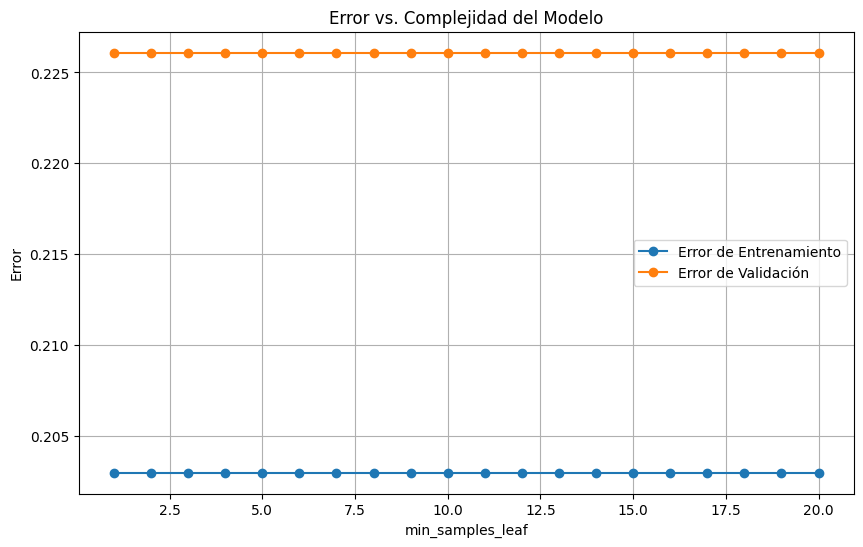

In [91]:
# Define una lista de valores de profundidad máxima que deseas probar
min_samples_leaf_values = range(1, 21, 1)

# Inicializa listas para almacenar los errores de entrenamiento y validación
train_errors = []
val_errors = []

# Itera a través de los valores de profundidad máxima
for min_samples_leaf in min_samples_leaf_values :
    # Crea y entrena un modelo de árbol con la profundidad máxima actual
    tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_split=50, min_samples_leaf=min_samples_leaf)
    tree.fit(X_train, y_train)

    # Realiza predicciones en los conjuntos de entrenamiento y validación
    y_train_pred = tree.predict(X_train)
    y_val_pred = tree.predict(X_val)

    # Calcula el error de entrenamiento y validación (puedes usar otras métricas si lo deseas)
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    val_error = 1 - accuracy_score(y_val, y_val_pred)

    # Agrega los errores a las listas
    train_errors.append(train_error)
    val_errors.append(val_error)

# Crea la gráfica de error vs. complejidad del modelo
plt.figure(figsize=(10, 6))
plt.plot(min_samples_leaf_values, train_errors, label='Error de Entrenamiento', marker='o')
plt.plot(min_samples_leaf_values, val_errors, label='Error de Validación', marker='o')
plt.title('Error vs. Complejidad del Modelo')
plt.xlabel('min_samples_leaf')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

**Observación:** Al parecer ya no es posible reducir más los errores antes mencionados con este parámetro. No es necesario incluirlo en el modelo debido a que no hay efecto alguno sobre la reducción del error.

### Técnica de regularización ccp_alpha

Para cerciorarse de que tanto la volatilidad del error en el subconjunto de entrenamiento como la **varianza** del modelo no se pueden reducir más se aplica la técnica de regularización llamada **control de costo de complejidad de la poda del árbol**. Esta técnica se incluye como parámetro al modelo actual para verificar si hay una reducción en el error.

Primero se revisa cual es el valor de ccp_alpha óptimo para reducir el error en ambos subconjuntos.

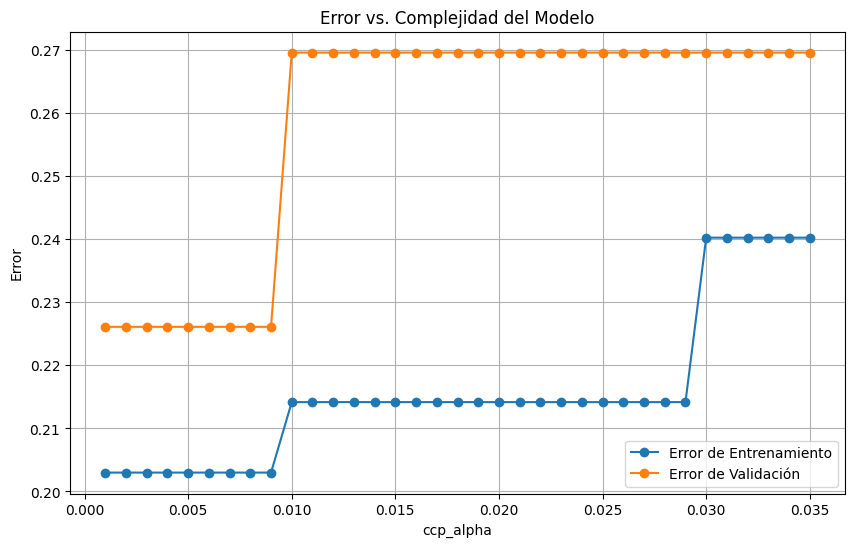

In [105]:
# Define una lista de valores de profundidad máxima que deseas probar
ccp_alpha_values = np.arange(0.001, 0.036, 0.001)

# Inicializa listas para almacenar los errores de entrenamiento y validación
train_errors = []
val_errors = []

# Itera a través de los valores de profundidad máxima
for ccp_alpha in ccp_alpha_values :
    # Crea y entrena un modelo de árbol con la profundidad máxima actual
    tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_split=50, ccp_alpha=ccp_alpha)
    tree.fit(X_train, y_train)

    # Realiza predicciones en los conjuntos de entrenamiento y validación
    y_train_pred = tree.predict(X_train)
    y_val_pred = tree.predict(X_val)

    # Calcula el error de entrenamiento y validación (puedes usar otras métricas si lo deseas)
    train_error = 1 - accuracy_score(y_train, y_train_pred)
    val_error = 1 - accuracy_score(y_val, y_val_pred)

    # Agrega los errores a las listas
    train_errors.append(train_error)
    val_errors.append(val_error)

# Crea la gráfica de error vs. complejidad del modelo
plt.figure(figsize=(10, 6))
plt.plot(ccp_alpha_values, train_errors, label='Error de Entrenamiento', marker='o')
plt.plot(ccp_alpha_values, val_errors, label='Error de Validación', marker='o')
plt.title('Error vs. Complejidad del Modelo')
plt.xlabel('ccp_alpha')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

**Observación:** Al parecer los valores iniciales de este parámetro son los que reducen más el error de los subconjuntos.

A continuación, se revisa si hay algún cambio en el comportamiento gráfico de error vs. tamaño del subconjunto de entrenamiento, considerando un valor de ccp_alpha de 0.005.

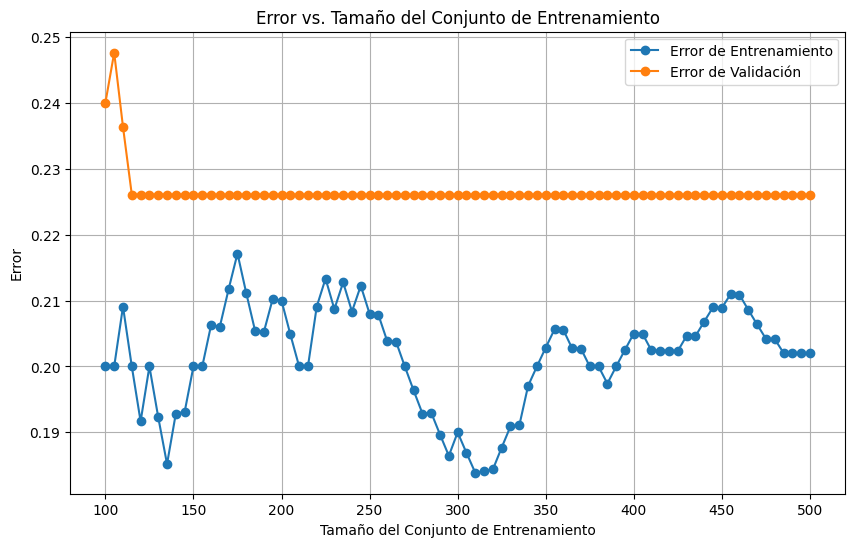

In [106]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_split=50, ccp_alpha=0.005)
tree.fit(X_train, y_train)
error_modelo(tree)

**Observación:** no se nota algún cambio en el comportamiento. Por lo tanto, la técnica de regularización no reduce los errores antes mencionados y no es ncesario incluirla en el modelo.

Por lo tanto, al no encontrar una reducción en el error llegamos a que el modelo que mejor se ajusta a las necesidades del problema es DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_split=50), con una **varianza** y **sesgo bajo**.

## Análisis de desempeño

### Métricas de desempeño para subconjuntos de entrenamiento y prueba

Para evaluar el desempeño del árbol de desición se prueba con los subconjuntos de entrenamiento y prueba para obtener las predicciones. Después se calculan las métricas de desempeño considerando las predicciones de cada subconjunto y los valores esperados.

In [92]:
tree = DecisionTreeClassifier(criterion="entropy", max_depth=5, min_samples_split=50)
tree.fit(X_train, y_train)

def metricas_desempeno(y, y_pred):
  confusion_matrix_results = confusion_matrix(y, y_pred)
  accuracy_score_results = accuracy_score(y, y_pred)
  precision_score_results = precision_score(y, y_pred)
  recall_score_results = recall_score(y, y_pred)
  f1_score_results = f1_score(y, y_pred)
  return confusion_matrix_results, accuracy_score_results, precision_score_results, recall_score_results, f1_score_results

# Metricas de desempeno para subconjunto de entrenamiento
y_pred_train = tree.predict(X_train)
confusion_matrix_train, accuracy_score_train, precision_score_train, recall_score_train, f1_score_train = metricas_desempeno(y_train, y_pred_train)

# Metricas de desempeno para subconjunto de prueba
y_pred_test = tree.predict(X_test)
confusion_matrix_test, accuracy_score_test, precision_score_test, recall_score_test, f1_score_test = metricas_desempeno(y_test, y_pred_test)

# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [accuracy_score_train, precision_score_train, recall_score_train, f1_score_train],
    'Test': [accuracy_score_test, precision_score_test, recall_score_test, f1_score_test]
})

metrics_df

,Metric,Train,Test
0,Accuracy,0.797020,0.750000
1,Precision,0.796992,0.733333
2,Recall,0.563830,0.511628
3,F1 Score,0.660436,0.602740


La métricas de desempeño del modelo sugieren un rendimiento razonablemente bueno en términos de exactitud, precisión, exhaustividad y f1 score tanto en el subconjunto de entrenamiento como en el de prueba. La diferencia entre las métricas en ambos subconjuntos no es muy grande, lo cual señala que el modelo no sufre de sesgo o una varianza excesiva.

### Matriz de confusión

Con motivo de comparar entre las predicciones generadas por el modelo y los valores que debieron de obtenerse se grafica la matriz de confusión para los subconjuntos de entrenamiento y prueba.

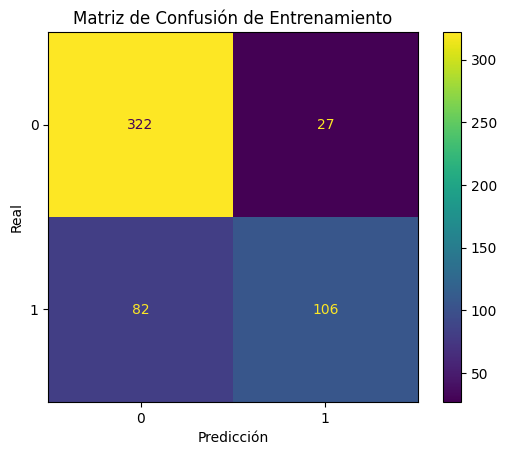

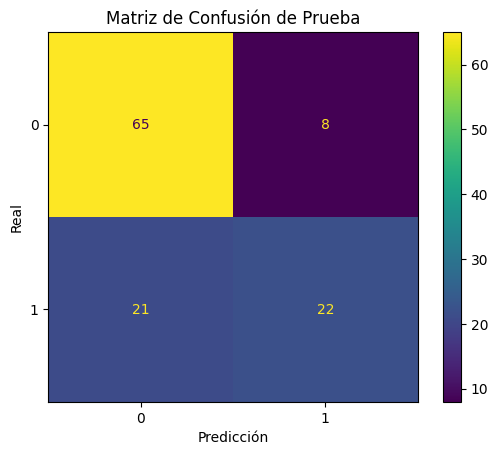

In [93]:
# Grafica la matriz de confusión de entrenamiento
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_train)
disp.plot()
plt.title('Matriz de Confusión de Entrenamiento')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

# Grafica la matriz de confusión de prueba
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_test)
disp.plot()
plt.title('Matriz de Confusión de Prueba')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

### Predicciones con modelo entrenado

Después de haber entrenado el modelo se realizan tres predicciones puntuales con datos aleatorios. Estos se comparan con los datos reales extraidos del subconjunto de prueba.

In [94]:
# Obtener la longitud de X_test (y_test tendrá la misma longitud)
n_samples = len(X_test)

# Elegir tres índices aleatorios únicos de X_test
random_indices = random.sample(range(n_samples), min(3, n_samples))

# Obtener las tres muestras de X_test y y_test utilizando los índices seleccionados
three_X_samples = [X_test[i] for i in random_indices]
three_y_samples = [y_test.iloc[i] for i in random_indices]

pred_puntuales = tree.predict(three_X_samples)

# Crear un diccionario con los datos
data = {
    'Real': three_y_samples,
    'Prediccion': pred_puntuales
}

# Crear el DataFrame
resultado_df = pd.DataFrame(data)

# Imprimir el DataFrame
resultado_df

,Real,Prediccion
0,1,1
1,0,0
2,0,1
